# 1. 加载数据集

In [1]:
# !mkdir ./dataset
# !wget https://bj.bcebos.com/ai-studio-online/9d140236f9ab4fc885ea57f6390a8f5ac102997cbb6549db9b5278e44aa2ce31?authorization=bce-auth-v1%2F5cfe9a5e1454405eb2a975c43eace6ec%2F2022-09-04T15%3A26%3A53Z%2F-1%2F%2F20eccb3d8f5781c7b2261eb18d830228ebf5e1f9e1567f6ed670d5d0539005b2&responseContentDisposition=attachment%3B%20filename%3Dfaces.zip
# !mv 9d140236f9ab4fc885ea57f6390a8f5ac102997cbb6549db9b5278e44aa2ce31?authorization=bce-auth-v1%2F5cfe9a5e1454405eb2a975c43eace6ec%2F2022-09-04T15:26:53Z%2F-1%2F%2F20eccb3d8f5781c7b2261eb18d830228ebf5e1f9e1567f6ed670d5d0539005b2 ./dataset/faces.zip
# !unzip -qd ./dataset/faces ./dataset/faces.zip 

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
import os
import cv2
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# class MyDataset(Dataset):
#     def __init__(self, data_dir, data_file, transform=None):
#         self.data_dir = data_dir
#         self.data_file = data_file
#         self.transform = transform

#     def __len__(self):
#         return len(self.data_file)
    
#     def __getitem__(self, index) -> torch.Tensor:
#         img = cv2.imread(self.data_dir + self.data_file[index])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = img / 255.0
#         img = torch.from_numpy(img).float().permute(2, 0, 1)

#         if self.transform:
#             img = self.transform(img)

#         return img
    
# data_dir = './dataset/faces/'
# data_file = os.listdir(data_dir)
# data_file.sort() # 不同系统下，文件夹中的文件顺序不同，所以排个序以为后续复现训练结果做准备
# dataset = MyDataset(data_dir, data_file)

torch.Size([1, 28, 28])


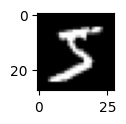

In [4]:
BATCH_SIZE = 64
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 野心小点，先试试minist数据集
dataloader = DataLoader(torchvision.datasets.MNIST('./dataset', train=True, download=True,
                                                    transform=torchvision.transforms.Compose([
                                                        torchvision.transforms.ToTensor(),
                                                        torchvision.transforms.Normalize(
                                                            (0.1307,), (0.3081,))
                                                    ])), batch_size=BATCH_SIZE, shuffle=True)
# 查看1张图片
plt.figure(figsize=(1, 1))
plt.imshow(dataloader.dataset[0][0].permute(1, 2, 0), cmap='gray')

# 查看数据集的shape
for i in dataloader:
    print(i[0][0].shape)
    break

# 2. 扩散过程（Diffusion Process）

In [5]:
# 计算超参数
T = 100 # 迭代次数, 也就是时间步数
beta_t = torch.linspace(0, 1, T)
alpha_t = 1 - beta_t
sqrt_alpha_t = torch.sqrt(alpha_t)
alpha_t_bar = torch.cumprod(alpha_t, dim=0)
sqrt_alpha_t_bar = torch.sqrt(alpha_t_bar)
sqrt_one_minus_alpha_t_bar = torch.sqrt(1 - alpha_t_bar)

In [6]:
# 计算扩散过程q中任意时刻的q(x_t)
def q_x(x0, t):
    """
    x0: 初始图片
    t: 时间步
    """
    x0 = x0
    t = t
    x_t = sqrt_alpha_t_bar[t] * x0 + sqrt_one_minus_alpha_t_bar[t] * torch.randn_like(x0)
    return x_t

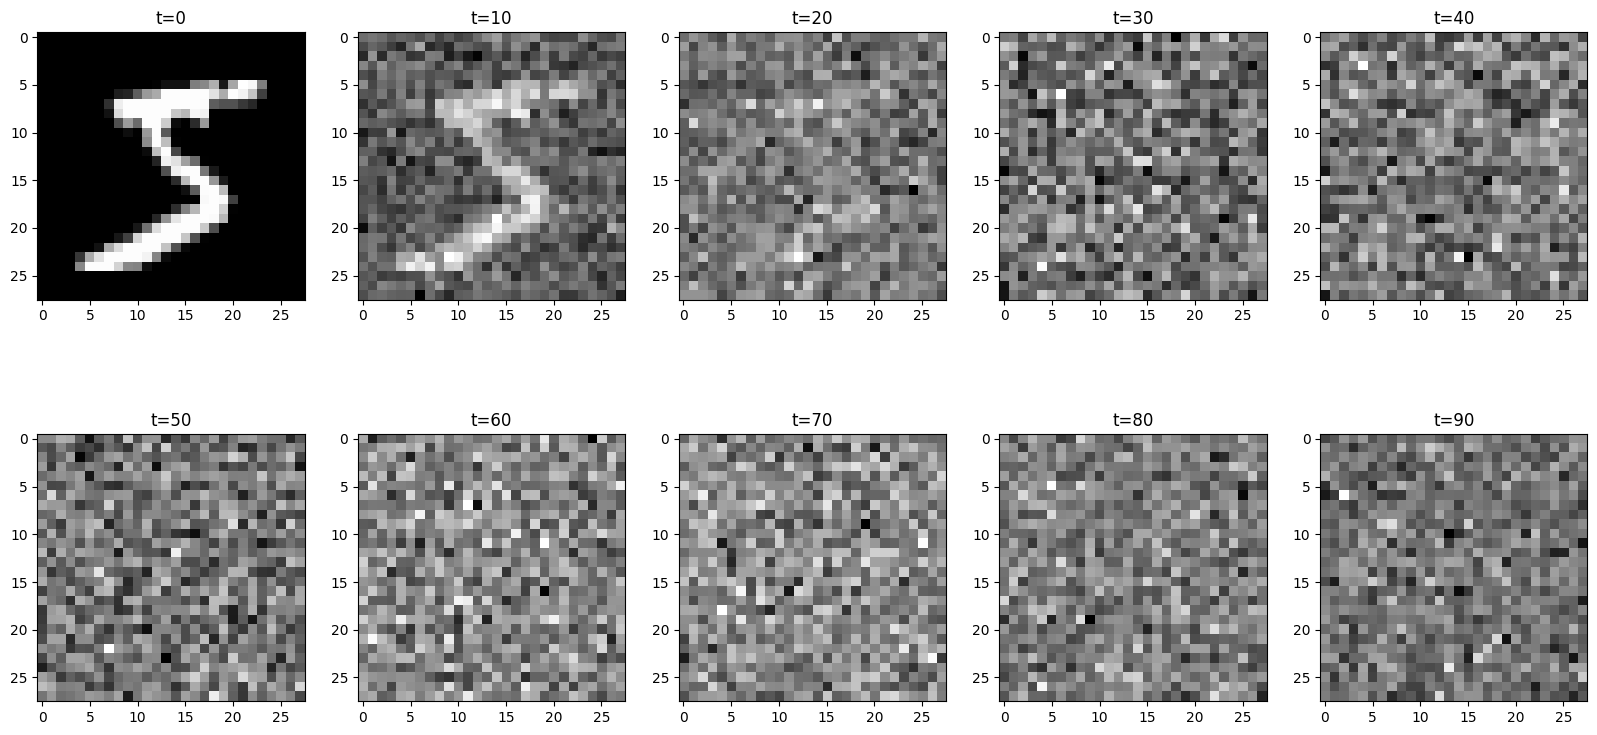

In [7]:
# 演示200步扩散过程
plt.figure(figsize=(20, 20))
for i in range(0, 100, 10):
    plt.subplot(4, 5, i // 10 + 1)
    plt.title(f't={i}')
    plt.imshow(q_x(dataloader.dataset[0][0], i).permute(1, 2, 0), cmap='gray')

# 3. 逆扩散过程（Reverse Diffusion Process）

## 3.1 UNet网络

In [8]:
# 搭建网络用于预测噪声
# 参考链接：https://zhuanlan.zhihu.com/p/609396803 (搭建UNet)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, T, embed_dim):
        """
        in_channels: 输入通道数
        out_channels: 输出通道数
        T: 总时间步数
        """
        super(UNet, self).__init__()

        # 时间步数的嵌入空间
        self.time_embedding = nn.Embedding(T, embed_dim)

        # 编码器（下采样路径）
        self.down_conv1 = nn.Sequential(
            self.conv_block(in_channels + 1, 64), # 1是嵌入的时间步信息的维度
            nn.MaxPool2d(kernel_size=2),
        )
        self.down_conv2 = nn.Sequential(
            self.conv_block(64, 128),
            nn.MaxPool2d(kernel_size=2),
        )
        # self.down_conv3 = nn.Sequential(
        #     self.conv_block(128, 256),
        #     nn.MaxPool2d(kernel_size=2),
        # )
        # self.down_conv4 = nn.Sequential(
        #     self.conv_block(256, 512),
        #     nn.MaxPool2d(kernel_size=2),
        # )
        # self.down_conv5 = nn.Sequential(
        #     self.conv_block(512, 1024),
        #     nn.MaxPool2d(kernel_size=2),
        # )

        # 解码器（上采样路径）
        # self.up_sample1 = self.conv_transpose_block(1024, 512)
        # self.up_conv1 = self.conv_block(1024, 512)
        # self.up_sample2 = self.conv_transpose_block(512, 256)
        # self.up_conv2 = self.conv_block(512, 256)
        # self.up_sample3 = self.conv_transpose_block(256, 128)
        # self.up_conv3 = self.conv_block(256, 128)
        self.up_sample4 = self.conv_transpose_block(128, 64)
        self.up_conv4 = self.conv_block(128, 64)

        self.restore_shape_layer = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)
        
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)
    

    def forward(self, x, t):
        # 新增一个通道嵌入时间信息
        batch_size = t.shape[0]
        t_embed = self.time_embedding(t).view(batch_size, 1, 28, 28)
        x = torch.cat([x, t_embed], dim=1)

        # 下采样
        x1 = self.down_conv1(x)
        x2 = self.down_conv2(x1)
        # x3 = self.down_conv3(x2)
        # x4 = self.down_conv4(x3)
        # x = self.down_conv5(x4)
        """
        x1: torch.Size([1, 64, 128, 128]),
        x2: torch.Size([1, 128, 64, 64]),
        x3: torch.Size([1, 256, 32, 32]),
        x4: torch.Size([1, 512, 16, 16]),
        x: torch.Size([1, 1024, 8, 8])
        """

        # 上采样
        # x = self.up_sample1(x)
        # x = torch.cat([x, x4], dim=1)
        # x = self.up_conv1(x)
        # x = self.up_sample2(x)
        # x = torch.cat([x, x3], dim=1)
        # x = self.up_conv2(x)
        # x = self.up_sample3(x)
        # x = torch.cat([x, x2], dim=1)
        # x = self.up_conv3(x)
        x = self.up_sample4(x2)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv4(x)
        x = self.restore_shape_layer(x)
        x = self.output_layer(x)

        return x

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        return block
    
    def conv_transpose_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
        return block

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


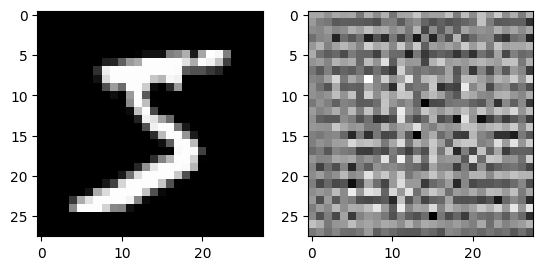

In [9]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=3, init_features=32, pretrained=False)
# 测试网络
model = UNet(1, 1, T, 28*28)
test_img = dataloader.dataset[0][0].unsqueeze(0)

t = torch.tensor(1)
t = t.unsqueeze(-1)
print(test_img.shape)
test_result = model(test_img, t)
print(test_result.shape)
plt.subplot(1, 2, 1)
plt.imshow(test_img.squeeze(0).permute((1, 2, 0)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(test_result.squeeze(0).permute((1, 2, 0)).detach().numpy(), cmap='gray')

## 3.2 Loss函数

In [10]:
def loss(model, x_0, sqrt_alpha_t_bar, sqrt_one_minus_alpha_t_bar, T, device=device):
    """
    model: 预测噪声的网络
    x_0: 初始图片
    sqrt_alpha_t_bar: sqrt(alpha_t_bar)
    sqrt_one_minus_alpha_t_bar: sqrt(1 - alpha_t_bar)
    T: 总时间步数

    对任意时刻t进行采样，计算损失
    """
    batch_size = x_0.shape[0]
    # 采样t，采样一半，另一半为T-1-t，防止t重复过多，提高训练效率
    t = torch.randint(0, T, size=(batch_size//2,))
    try:
        t = torch.cat([t, T-1-t], dim=0)
    except:
        t = t
    t = t.unsqueeze(-1)

    x_0_coeff = sqrt_alpha_t_bar[t].unsqueeze(-1).unsqueeze(-1) # x0的系数
    epsilon_coeff = sqrt_one_minus_alpha_t_bar[t].unsqueeze(-1).unsqueeze(-1) # 噪声的系数
    epsilon = torch.randn_like(x_0)
    x = x_0_coeff * x_0 + epsilon_coeff * epsilon # 采样得到的x
    x = x.to(device)
    t = t.to(device)
    epsilon = epsilon.to(device)
    epsilon_predict = model(x, t)
    return F.mse_loss(epsilon, epsilon_predict)

## 3.3 逆扩散采样

逆扩散过程p中，我们要训练的是 $p_{\theta}(x_{t-1} | x_t)$

在扩散过程q中，t-1时刻噪声的后验概率为 $q(x_{t-1} | x_t, x_0)\ \~{} \ N(\tilde \mu_t(x_t, x_0),\ \tilde \beta_t \mathbf{I})$

其中 $\tilde \mu_t(x_t, x_0) = \cfrac{1}{\sqrt{\alpha_t} } (x_t - \cfrac{\beta_t}{\sqrt{1-\alpha_t}} \cdot z_t),\ where\ z_t\ \~{} \ N(0,\ \mathbf{I})$, $\tilde \beta_t $为常数



In [11]:
def p_sample(model, x, t, beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t_bar):
    """
    model: 预测噪声的网络
    x: 初始图片
    t: 时间步
    beta_t: beta_t
    sqrt_alpha_t_bar: sqrt(alpha_t_bar)
    sqrt_one_minus_alpha_t_bar: sqrt(1 - alpha_t_bar)

    从 x[t] 采样得到 x[t-1]
    """
    t = torch.tensor([t])
    epsilon_theta = model(x, t)

    mean = (1 / sqrt_alpha_t[t]) * (x - beta_t[t] / sqrt_one_minus_alpha_t_bar[t] * epsilon_theta)
    var = beta_t[t].sqrt()

    sample = mean + var * torch.randn_like(x)

    return (sample)
    
    

def p_sample_loop(model, shape, T, beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t_bar):
    """
    从 x[T] 恢复 x[T-1], x[T-2], ..., x[0]
    """
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for t in reversed(range(T)):
        cur_x = p_sample(model, cur_x, t, beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t_bar)
        x_seq.append(cur_x)

## 3.4 训练模型

In [12]:
n_epoch = 100
model = UNet(1, 1, T, 28*28)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from tqdm import tqdm

def train(model, optimizer, n_epoch, dataloader, T, beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t_bar):
    model.train()
    for epoch in range(n_epoch):
        with tqdm(dataloader, total=len(dataloader)) as t:
            for batch in t:
                batch = batch[0]
                optimizer.zero_grad()
                loss_value = loss(model, batch, sqrt_alpha_t_bar, sqrt_one_minus_alpha_t_bar, T)
                loss_value.backward()
                optimizer.step()
                t.set_description(f'epoch:{epoch}, loss:{loss_value:.4f}')

        if epoch % 20 == 0:
            torch.save(model.state_dict(), f'./model/model_{epoch}.pth')
            x_seq = p_sample_loop(model, (1,3,256,256), T, beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t_bar)
            plt.figure(figsize=(20, 20))
            for i in range(0, 250, 10):
                plt.subplot(5, 5, i // 10 + 1)
                plt.title(f't={i}')
                plt.imshow(x_seq[i].squeeze(0).permute(1, 2, 0).detach().numpy())

train(model, optimizer, n_epoch, dataloader, T, beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t_bar)

# 保存模型
import os
if not os.path.exists('./model'):
    os.mkdir('./model')
torch.save(model.state_dict(), './model/model.pth')

  0%|          | 0/938 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[64, 2, 28, 28] to have 4 channels, but got 2 channels instead

In [ ]:
64*28*28


50176